## Visualização de filtros e mapas de recursos em redes neurais convolucionais

Modelo utilizado: VGG16

Keras fornece muitos exemplos de modelos de classificação de imagens de bom desempenho desenvolvidos por diferentes grupos de pesquisa para o ImageNet Large Scale Visual Recognition Challenge, ou ILSVRC. Um exemplo é o modelo *VGG-16* que obteve os melhores resultados na competição de 2014.

Este é um bom modelo a ser usado para visualização porque tem uma estrutura uniforme simples de camadas convolucionais e agrupadas ordenadas em série, é profundo com 16 camadas aprendidas e teve um desempenho muito bom, o que significa que os filtros e mapas de recursos resultantes capturarão recursos úteis.

In [ ]:
from keras.applications.vgg16 import VGG16
# carrega o modelo
model = VGG16()
# sumário do modelo
model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## Visualizando filtros nas camadas convolucionais

A visualização mais simples de realizar talvez seja plotar os filtros (kernels) aprendidos diretamente.

Os filtros aprendidos são simplesmente pesos, mas por causa da estrutura bidimensional especializada dos filtros, os valores de peso têm uma relação espacial entre si e traçar cada filtro como uma imagem bidimensional é interessante.

Podemos acessar todas as camadas do modelo por meio da propriedade model.layers .

Cada camada possui uma propriedade layer.name , onde as camadas convolucionais têm uma convolução de nomenclatura como o bloco # _conv # , onde o ' # ' é um inteiro. Portanto, podemos verificar o nome de cada camada e pular qualquer uma que não contenha a string 'conv'.

Cada camada convolucional possui dois conjuntos de pesos.

Um é o bloco de filtros e o outro é o bloco de valores de polarização. Eles são acessíveis por meio da função layer.get_weights(). 

O código abaixo imprime uma lista de detalhes da camada, incluindo o nome da camada e a forma dos filtros na camada.

In [ ]:
# summariza os filtros
for layer in model.layers:
	# verifica se é camada convolucional
	if 'conv' not in layer.name:
		continue
	# pega os filtros (pesos)
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


Todas as camadas convolucionais usam filtros 3 × 3, que são pequenos e talvez fáceis de interpretar.

O número de canais de um filtro deve corresponder ao número de canais da entrada do filtro.

Podemos ver que para a imagem de entrada com três canais para vermelho, verde e azul, cada filtro tem uma profundidade de três. Podemos então visualizar um filtro como um gráfico com três imagens, uma para cada canal, ou compactar todas as três em uma imagem de cor única, ou mesmo apenas olhar para o primeiro canal e assumir que os outros canais terão a mesma aparência. O problema é que temos 63 outros filtros que gostaríamos de visualizar.

Podemos recuperar os filtros da primeira camada convolucional.

Os valores de peso provavelmente serão pequenos valores positivos e negativos centralizados em torno de 0,0.Vamos normalizar seus valores para o intervalo 0-1 para torná-los fáceis de visualizar.

Vamos enumerar os cinco primeiros filtros dos 64 no bloco e representar graficamente cada um dos três canais de cada filtro.

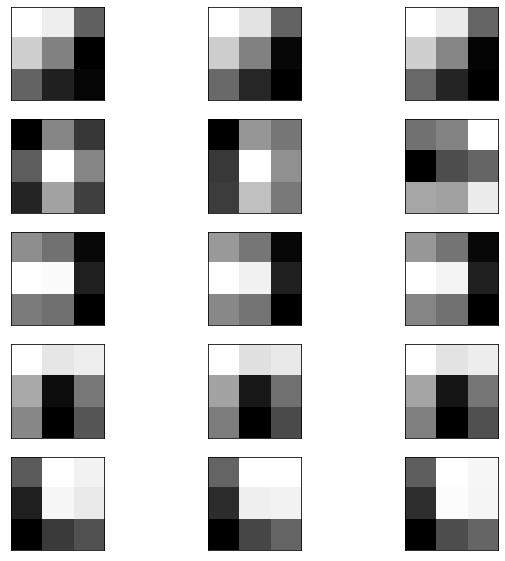

In [ ]:
from matplotlib import pyplot
# recupera os filtros (pesos) da segunda camada (primeira camada convolucional)
filters, biases = model.layers[1].get_weights()
# normaliza para o intervalo [0,1] para torná-los fáceis de visualizar
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plota os primeiros filtros
pyplot.figure(figsize=(10, 10))
n_filters, ix = 5, 1
for i in range(n_filters):
	# pega o filtro
	f = filters[:, :, :, i]
	# plota cada canal separadamente
	for j in range(3):
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plota o canal do filtro em nível de cinza
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# mostra a figura
pyplot.show()

Temos então 5 linhas de três imagens, ou 15 imagens, uma linha para cada filtro e uma coluna para cada canal

Podemos ver que em alguns casos, o filtro é o mesmo em todos os canais (a primeira linha), e em outros, os filtros são diferentes (a última linha).

Os quadrados escuros indicam pesos pequenos ou inibitórios e os quadrados claros representam pesos grandes ou excitatórios. 

## Como visualizar mapas de recursos

Os mapas de ativação, chamados de mapas de recursos (de atributos ou de características), capturam o resultado da aplicação dos filtros à entrada, como a imagem de entrada ou outro mapa de recursos.

A ideia de visualizar um mapa de recursos para uma imagem de entrada específica seria entender quais recursos da entrada são detectados ou preservados nos mapas de recursos. 

A expectativa é a de que os mapas de recursos próximos à entrada detectem detalhes pequenos ou refinados, enquanto os mapas de recursos próximos à saída do modelo capturem recursos mais gerais.

Para explorar a visualização de mapas de características usaremos uma imagem de um gato.

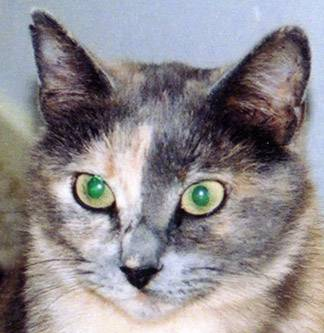

In [ ]:
from IPython.display import Image
Image(filename = 'cat.1700.jpg')


O código abaixo irá enumerar todas as camadas no modelo e imprimir o tamanho de saída ou o tamanho do mapa de recursos para cada camada convolucional, bem como o índice de camada no modelo. É possível ver as mesmas formas de saída que vimos no resumo do modelo, mas neste caso apenas para as camadas convolucionais.

In [ ]:
# summarize as formas dos mapas de atributos
for i in range(len(model.layers)):
	layer = model.layers[i]
	# verifica se é uma camada convolucional
	if 'conv' not in layer.name:
		continue
	# sumariza a forma apenas das camadas convolucionais
	print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


Depois de carregar o modelo VGG, podemos definir um novo modelo que produz um mapa de características da primeira camada convolucional (índice 1) da seguinte maneira:

In [ ]:
from keras.models import Model
# redefine o modelo para a saída logo após a primeira camada oculta
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

Fazer uma previsão com este modelo fornecerá o mapa de recursos para a primeira camada convolucional para uma determinada imagem de entrada fornecida. 

Após definir o modelo, precisamos carregar a imagem do gato com o tamanho esperado pelo modelo, neste caso, 224 × 224.

In [ ]:
from keras.preprocessing.image import load_img
# carrega a imagem com o formato requerido
img = load_img('cat.1700.jpg', target_size=(224, 224))

Em seguida, o objeto [PIL](https://pt.wikipedia.org/wiki/Python_Imaging_Library) de imagem precisa ser convertido em um array NumPy de dados de pixel e expandido de um array 3D para um array 4D com as dimensões de [ samples, rows, cols, channels ], onde temos apenas uma amostra.

In [ ]:
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
# converte a imagem para um array
img = img_to_array(img)
# expande as dimensões de modo que ele represente a uma única amostra
img = expand_dims(img, axis=0)

Os valores de pixel, então, precisam ser dimensionados apropriadamente para o modelo VGG.

In [ ]:
from keras.applications.vgg16 import preprocess_input
# prepara a imagem (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

Agora estamos prontos para obter o mapa de recursos. Podemos fazer isso facilmente chamando a função model.predict () e passando a única imagem preparada.

In [ ]:
# pega o mapa de atributos para a primeira camada escondida
feature_maps = model.predict(img)

Sabemos que o resultado será um mapa de recursos com 224x224x64. Podemos plotar todas as 64 imagens bidimensionais como um quadrado de 8 × 8 de imagens.

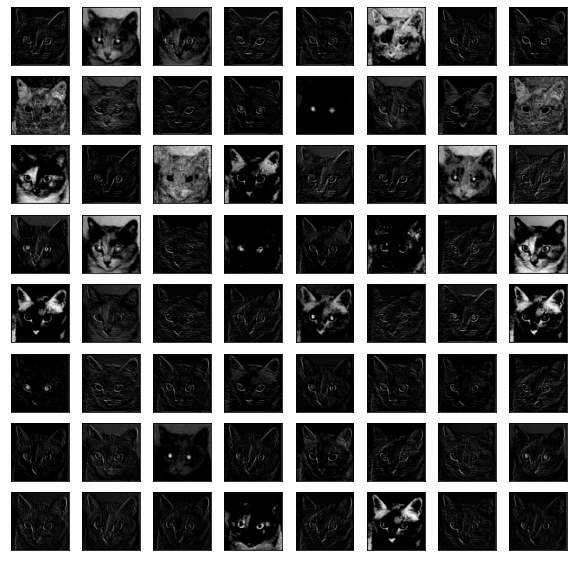

In [ ]:
# plota todos os 64 mapas num grid (subplot) 8x8
pyplot.figure(figsize=(10, 10))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# especifica o subplot e eixo
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plota o canal do filtro 
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# mostra a figura
pyplot.show()

A saída acima mostra todos os 64 mapas de recursos.

Podemos ver que o resultado da aplicação dos filtros na primeira camada convolucional são muitas versões da imagem do gato com diferentes características destacadas.

Por exemplo, algumas linhas de destaque, outras focam o plano de fundo ou o primeiro plano.

E lembre-se: este modelo é muito menor que o modelo VGG16, mas ainda usa os mesmos pesos (filtros) na primeira camada convolucional que o modelo VGG16:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


Este é um resultado interessante e geralmente corresponde à nossa expectativa. Poderíamos atualizar o exemplo para plotar os mapas de recursos da saída de outras camadas convolucionais específicas.

Outra abordagem seria coletar a saída dos mapas de recursos de cada bloco do modelo em uma única passagem e, em seguida, criar uma imagem de cada um.

Existem cinco blocos principais na imagem (por exemplo, bloco 1, bloco 2, etc.) que terminam em uma camada de agrupamento. Os índices de camada da última camada convolucional em cada bloco são [2, 5, 9, 13, 17].

Podemos definir um novo modelo que possui várias saídas, uma saída de mapa de recursos para cada uma das últimas camadas convolucionais em cada bloco; por exemplo:

In [ ]:
# recarrega o modelo original
model = VGG16()
# redefine o modelo com múltiplas saídas
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i+1].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
#model.summary()

Fazer uma previsão com este novo modelo resultará em uma lista de mapas de recursos.

In [ ]:
feature_maps = model.predict(img)

Sabemos que o número de mapas de características (por exemplo, profundidade ou número de canais) em camadas mais profundas é muito mais do que 64, como 256 ou 512. No entanto, podemos limitar o número de mapas de características visualizados em 64 para consistência.


Bloco 1 :


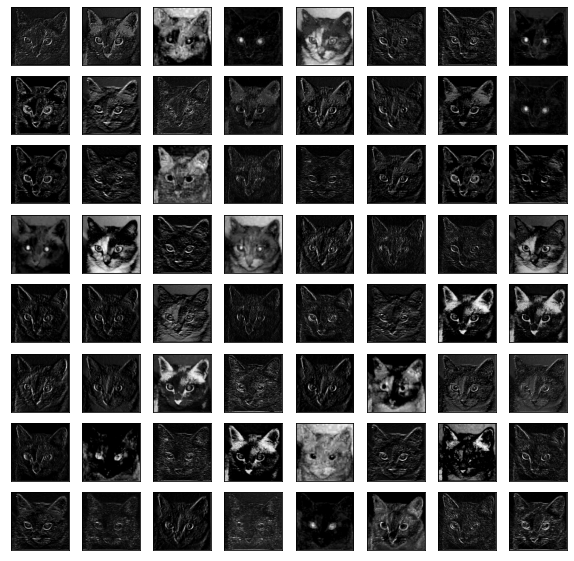


Bloco 2 :


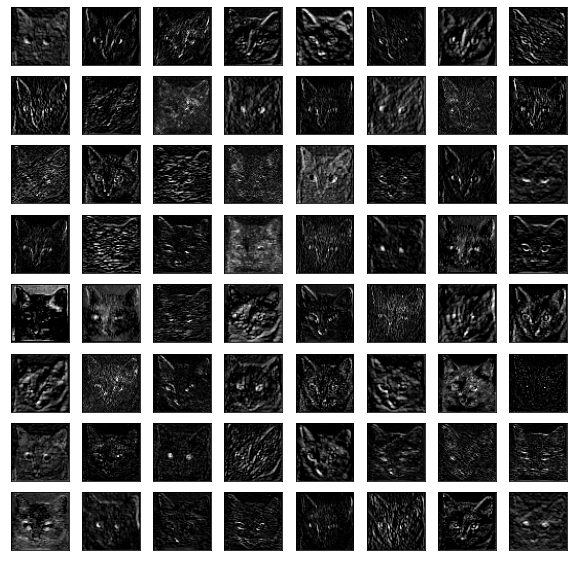


Bloco 3 :


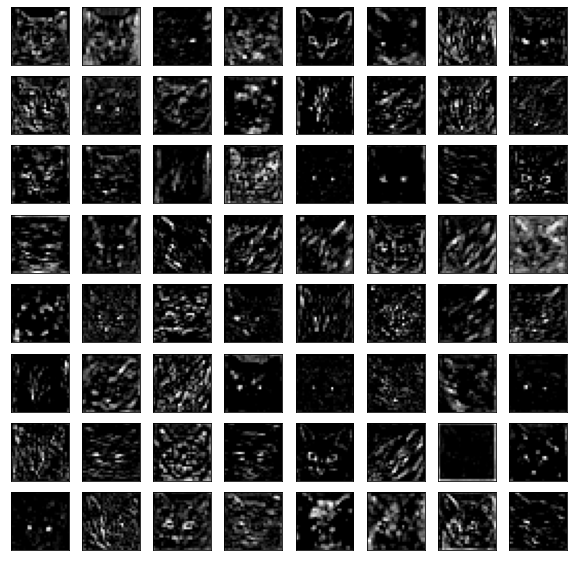


Bloco 4 :


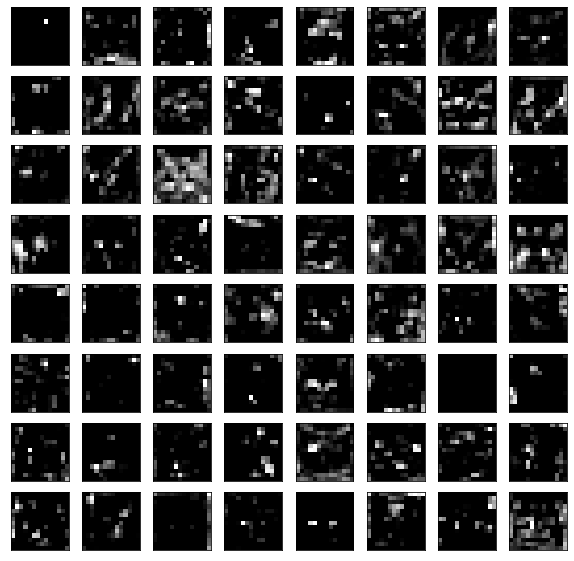


Bloco 5 :


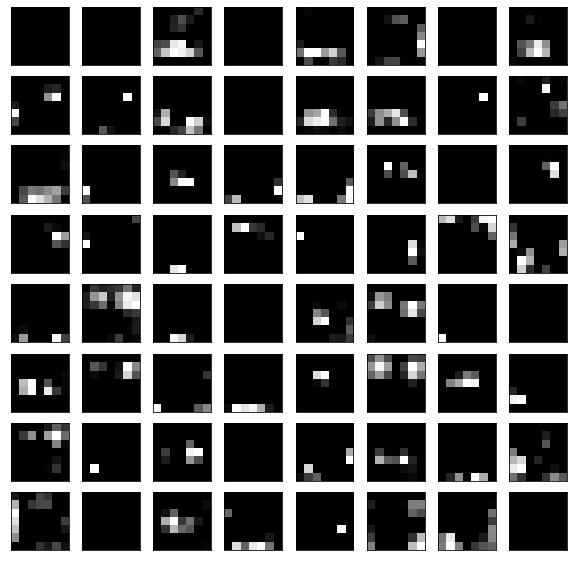

In [ ]:
square = 8
block = 0
for fmap in feature_maps:
  block = block + 1
  print('\nBloco',block,':')
  pyplot.figure(figsize=(10, 10))
	# plot all 64 maps in an 8x8 squares
  ix = 1
  for _ in range(square):
    for _ in range(square):
      # specify subplot and turn of axis
      ax = pyplot.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
			# plot filter channel in grayscale
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
	# show the figure
  pyplot.show()

A execução do exemplo resulta em cinco grids que mostram os mapas de recursos dos cinco blocos principais do modelo VGG16.

Podemos ver que os mapas de recursos mais próximos da entrada do modelo capturam muitos detalhes finos na imagem e que, à medida que avançamos mais no modelo, os mapas de recursos mostram cada vez menos detalhes.

Esse padrão era esperado, pois o modelo abstrai os recursos da imagem em conceitos mais gerais que podem ser usados ​​para fazer uma classificação. Embora não esteja claro na imagem final que o modelo viu um gato, geralmente perdemos a capacidade de interpretar esses mapas de recursos mais profundos.



Fonte: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb